## An introduction to Inference in Pyro

https://pyro.ai/examples/intro_part_ii.html

Pyroを用いた推論の例として、簡単な物理的問題を解く

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
import torch

import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist
%matplotlib inline

pyro.set_rng_seed(101)

## A Simple Example

ある物体の重さを測定するケースを考える。ただし、測定器の精度が悪く、ばらつきを持つ。また、見た目や事前の材料知識から重さを推測することもできる(同様にばらつきを持つ)。詳細条件は下記。

+ weight | guess ~ Normal(guess, 1)
+ measurement | guess, weight ~ Normal(weight, 0.75)

まず、この条件での測定器(scale)関数を定義する。(引数：guess, 戻り値: 測定器の表示値)

In [2]:
def scale(guess):
    weight = pyro.sample("weight", dist.Normal(guess, 1.0))
    return pyro.sample("measurement", dist.Normal(weight, 0.75))

## Conditioning

観測データからモデルを調整し、欲しいデータの分布を求める。ここでは、guess=8.5, measurement=9.5であったときの、weightの確率分布を求めたい。

pyroでは、pyro.condition 関数を用いて、サンプルの値を拘束できる。ここでは、guessを引数として、measurementを9.5と固定する。これにより、func(guess)を行うと、出力は9.5固定で、内部のweightがランダムに変化する関数となる。

+ pyro.condition

  - 引数 : モデル、観測データの辞書
  - 返り値 : 新しいモデル (入出力は同じで、引数に取った観測データは常に与えられた値となる)

In [3]:
conditioned_scale = pyro.condition(scale, data={"measurement": 9.5})

#以下のように、defによる関数定義の形で記載することや、lambda式により定義することもできる。
def deferred_conditioned_scale(measurement, guess):
    return pyro.condition(scale, data={"measurement": measurement})(guess)


pyro.conditionで再定義するよりも、個々のpyro.sampleを定義する時点で観測値を直接決める方が便利なことも多い。その場合は、オプションobsを用いることで実現できる。(下記)

In [4]:
def scale_obs(guess): # equivalent to conditioned_scale above
    weight = pyro.sample("weight", dist.Normal(guess, 1.0))
    #ここでmeasurement = 9.5と定義する
    return pyro.sample("measurement", dist.Normal(weight, 0.75), obs=torch.Tensor([9.5]))

Pearl's do を表現するpyro.do 関数もある。これは、ある変数が、"観測した結果xであった"と、"xになるようにした"場合を区別する関数。交絡が存在する場合にこの差は重要らしい。

## Flexible Approximate Inference With Guide Functions

+ pyro.infer.SVIのようなpyroないの推定アルゴリズムを用いて、任意の確率関数を近似事後確率分布とできる。この近似事後確率分布をguide functions または guides と呼ぶ
+ Guide functions は以下の条件を満たす必要がある。
 1. 全ての観測されていないmodel内の変数がguide内にも現れる
 1. 引数がmodelとguideで同じである。
+ 現在、pyroでは以下の手法が実装されている
 1. Importance sampling
 1. MCMC
 1. Stochastic variational inference (SVI)
 
今回のケースでは、質量の平均・標準偏差の理論値を容易に計算できる(平均9.14, 標準偏差0.6) 推論の妥当性確認のためその関数を用意する

In [5]:
def perfect_guide(guess):
    loc = (0.75**2 * guess + 9.5) / (1 + 0.75**2) #9.14
    scale = np.sqrt(0.75**2/(1 + 0.75**2)) # #0.6
    return pyro.sample("weight", dist.Normal(loc,scale))

## Parametrized Stochastic Functions and Variational Inference

+ variational inference : 変分ベイズ法
+ pyro.param("名前", tensor(初期値))で、推定するパラメータの命名および初期値代入を行う。このとき、constraintオプションでパラメータの変化範囲を指定できる。指定にはpytorchのconstraints moduleを用いる。(https://pytorch.org/docs/master/distributions.html#module-torch.distributions.constraints)
+ 本例では、標準偏差は必ず0以上のため、その条件を指定する(constraints.positive)


In [6]:
from torch.distributions import constraints

def scale_parametrized_guide_constrained(guess):
    a = pyro.param("a", torch.tensor(guess))
    b = pyro.param("b", torch.tensor(1.), constraint = constraints.positive)
    return pyro.sample("weight", dist.Normal(a, b))

+ Stochastic variational inferenceの特徴は下記
 1. パラメータは常に実数テンソル
 1. モデルとガイドの実行履歴のサンプルからモンテカルロ法により損失関数を推定する
 1. 理想のパラメータを探すために確率勾配降下法(stochastic gradient descent; SGD)を用いる
 
+ Pytorchの機能により、上記の計算について、GPUの使用や高速化が可能となっている
+ SVIの詳細は https://pyro.ai/examples/svi_part_i.html　を参照


In [7]:
guess = 8.5

pyro.clear_param_store()
svi = pyro.infer.SVI(model=conditioned_scale,
                     guide=scale_parametrized_guide_constrained,
                     optim=pyro.optim.SGD({"lr": 0.001, "momentum":0.1}),
                     loss=pyro.infer.Trace_ELBO())


losses, a,b  = [], [], []
num_steps = 2500
for t in range(num_steps):
    losses.append(svi.step(guess))
    a.append(pyro.param("a").item())
    b.append(pyro.param("b").item())
    



a =  9.107148170471191
b =  0.6064099669456482


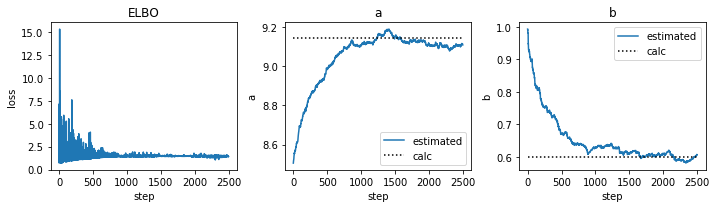

In [8]:
#データのプロット記法を元のコードから変更している
print('a = ',pyro.param("a").item())
print('b = ', pyro.param("b").item())

fig, axes=plt.subplots(nrows=1, ncols=3, figsize=(10,3))
axes[0].plot(losses)

axes[1].plot(a, label='estimated')
axes[1].plot([0,num_steps],[9.14,9.14], 'k:', label='calc')
axes[1].legend()

axes[2].plot(b, label='estimated')
axes[2].plot([0,num_steps],[0.6,0.6], 'k:', label='calc')
axes[2].legend()

axes[0].set_title("ELBO")
axes[1].set_title("a")
axes[2].set_title("b")
for i in range(3):
    axes[i].set_xlabel("step")

axes[0].set_ylabel("loss");
axes[1].set_ylabel('a')
axes[2].set_ylabel('b')

#axes[2].tight_layout()
fig.tight_layout()
plt.show()

## appendix

MCMCを用いて同様の推定計算を試してみる。
とりあえずの実装のみ。各機能の詳細や細かい調整手法は別途調べる。

In [9]:
#mcmcの際は観測値もtensorデータとする必要があるため、関数再定義。guess, measuredどちらも変数とした。
def scale_mcmc(guess, measured):
    weight = pyro.sample("weight", dist.Normal(guess, 1.0))
    return pyro.sample("measurement", dist.Normal(weight, 0.75), obs=measured)

guess = torch.Tensor([8.5])
measured = torch.Tensor([9.5])

num=10000
nuts_kernel = pyro.infer.NUTS(scale_obs)
mcmc = pyro.infer.MCMC(nuts_kernel, num_samples=num,warmup_steps=500)
mcmc.run(guess)
samples = mcmc.get_samples()
mcmc.summary()

Sample: 100%|████████████████████████████████████| 10500/10500 [00:27, 384.50it/s, step size=9.92e-01, acc. prob=0.899]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
 weight[0]      9.14      0.61      9.13      8.13     10.11   3787.64      1.00

Number of divergences: 0


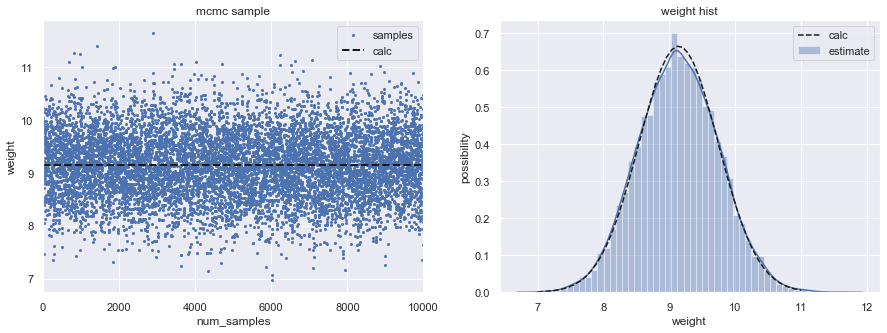

In [10]:
sns.set(context='notebook')

fig, axes=plt.subplots(nrows=1, ncols=2, figsize=(15,5))
axes[0].plot(samples['weight'].squeeze(), label='samples', marker='o', markersize=2, linestyle='')
axes[0].plot([0,num],[9.14,9.14], 'k--', label='calc', linewidth=2)

sns.distplot(samples['weight'].squeeze(), label='estimate',ax=axes[1])
calc_x=np.linspace(7,11)
calc_y=norm.pdf(calc_x,9.14,0.6)
axes[1].plot(calc_x,calc_y, 'k--', label='calc')

axes[0].set_title('mcmc sample')
axes[0].set_xlabel('num_samples')
axes[0].set_ylabel('weight')
axes[0].set_xlim([0,10000])
axes[0].legend()

axes[1].set_title('weight hist')
axes[1].set_xlabel('weight')
axes[1].set_ylabel('possibility')
axes[1].legend()

plt.show()

MCMCでも理論値とほぼ一致する結果が得られた。実行時間はかかるが、事後分布の形状が予想できない場合に役立つ